# Episode plots

In [54]:
from huggingface_hub import hf_hub_download, HfApi
from plotnine import ggplot, aes, geom_point, geom_line, ggtitle
from skopt import load
from stable_baselines3 import PPO

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.utils import evaluate_agent
from rl4fisheries.envs.asm_fns import get_r_devs_mean_corrected

import numpy as np
import pandas as pd
import ray

In [24]:
PLOT_T_MAX = 300 # plot only 300 timesteps for easier visuals

## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}

## Load

In [25]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM1.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM2.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM3.pkl")

esc_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM1.pkl")
esc_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM2.pkl")
esc_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM3.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM1.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM2.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM3.pkl")

In [26]:
cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

esc_UM1 = load(esc_UM1_file)
esc_UM2 = load(esc_UM2_file)
esc_UM3 = load(esc_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [27]:
base_fname = "sb3/rl4fisheries/results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-64-32-16-chkpnt3.zip")
PPO_mw_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM1-64-32-16-chkpnt3.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-chkpnt1.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-64-32-16-chkpnt1.zip")
PPO_mw_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM2-64-32-16-chkpnt4.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-chkpnt3.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-64-32-16-chkpnt5.zip")
PPO_mw_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM3-64-32-16-chkpnt2.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-chkpnt4.zip")

In [28]:
PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_mw_UM1 = PPO.load(PPO_mw_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_mw_UM2 = PPO.load(PPO_mw_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_mw_UM3 = PPO.load(PPO_mw_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

## Utilities

Use 2 observations for all agents! (It's ok, they'll only use the first observation - biomass - but, the plots will also keep track of the mean weight (the second observation.)

In [29]:
def obs_to_mwt(obs, env):
    return env.parameters['min_wt'] + (
        env.parameters['max_wt'] - env.parameters['min_wt']
    ) * (obs + 1) / 2

def obs_to_bms(obs, env):
    return env.bound * (obs + 1) / 2

def safe_predict(agent, obs, observed_var):
    if observed_var == '2o':
        if len(obs) == 2:
            return agent.predict(obs)
    if observed_var == 'mw':
        if len(obs) == 2:
            return agent.predict(np.float32([obs[1]]))
        if len(obs) == 1:
            return agent.predict(obs)
    if observed_var == 'bm':
        if len(obs) == 2:
            # print(obs[0], agent.predict(np.float32([obs[0]]))) ###########
            return agent.predict(np.float32([obs[0]]))
        if len(obs) == 1:
            return agent.predict(obs)
    print(f'problem in safe_predict. obs: {obs}, observed_var: {observed_var}')
    return

def simulate_episode(*, env, agent, observed_var: 'bm, mw or 2o'):
    bms = []
    mwt = []
    ts = []
    fishing = []
    rews = []
    obs, _ = env.reset()
    #
    for t in range(env.Tmax):
        action, info = safe_predict(agent, obs, observed_var) # agent.predict(obs)
        # print(obs, action, end="\n\n")
        new_obs, rew, term, trunc, info = env.step(action)
        #
        bms.append(obs_to_bms(obs=obs[0], env=env))
        mwt.append(obs_to_mwt(obs=obs[1], env=env))
        ts.append(t)
        fishing.append(0.5 * (1 + action[0]))
        rews.append(rew)
        obs = new_obs
        if term or trunc:
            break
    return {
        't': ts,
        'biomass': bms,
        'mean_wt': mwt,
        'fishing_intensity': fishing,
        'rew': rews,
    }
    
def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}  

## Reproducible noise env

In [55]:
r_devs = get_r_devs_mean_corrected(n_year=AsmEnv().Tmax)

env_UM1 = AsmEnv(
    config = {**CFG_UM1_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

env_UM2 = AsmEnv(
    config = {**CFG_UM2_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

env_UM3 = AsmEnv(
    config = {**CFG_UM3_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

0 20 177 934 934 66


<Axes: xlabel='t'>

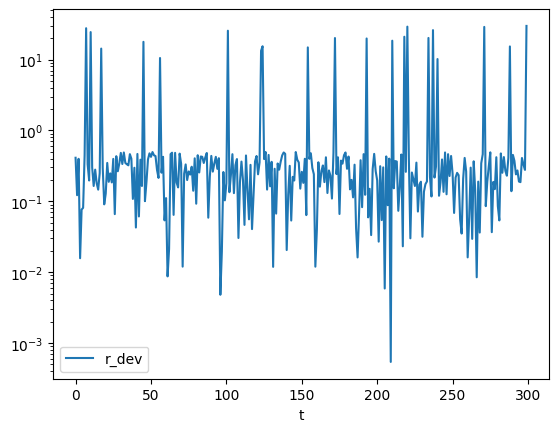

In [70]:
rdev_df = pd.DataFrame({'r_dev': r_devs, 't': list(range(len(r_devs)))})
print(
    rdev_df[rdev_df.r_dev < 0.0001].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.01].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.1].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.5].r_dev.count(),
    rdev_df[rdev_df.r_dev < 1].r_dev.count(),
    rdev_df[rdev_df.r_dev > 10].r_dev.count(),
)
rdev_df[rdev_df.t < PLOT_T_MAX].plot(x='t', logy=True)

## UM1

Caution: sometimes PPO_bm_UM1 seems to go out of wack and start predicting a constant action. This is not the behavior that it's supposed to have and the value of the constant action can be quite erratic (usually leading to near-zero rewards, inconsistent with notebook 2). If this happens, usually re-loading the model fixes the problem. Not really sure where the bug is coming from ATM.

In [59]:
ppo_bm_UM1_ep = pd.DataFrame(simulate_episode(env=env_UM1, agent=PPO_bm_UM1, observed_var='bm'))
ppo_2o_UM1_ep = pd.DataFrame(simulate_episode(env=env_UM1, agent=PPO_2o_UM1, observed_var='2o'))
ppo_mw_UM1_ep = pd.DataFrame(simulate_episode(env=env_UM1, agent=PPO_mw_UM1, observed_var='mw'))

cr_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = CautionaryRule(
            env = env_UM1,
            **(from_radius_theta(*cr_UM1.x)), 
        ), 
    observed_var='bm',
))

esc_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = ConstEsc(
            env = env_UM1,
            escapement=cr_UM1.x[0], 
        ), 
    observed_var='bm',
))

msy_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = Msy(
            env = env_UM1,
            mortality=msy_UM1.x[0], 
        ), 
    observed_var='bm',
))

<Axes: title={'center': 'Constant Intensity, 129.50'}, xlabel='t'>

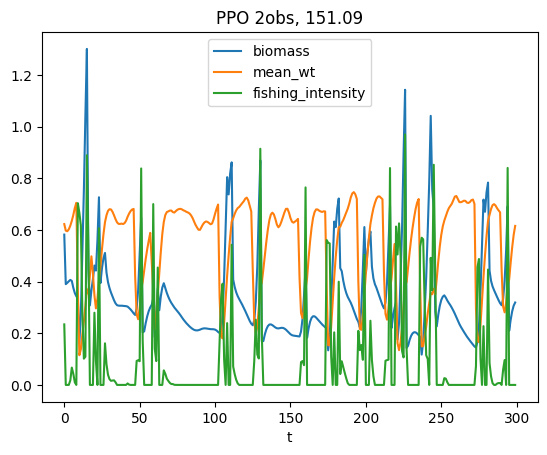

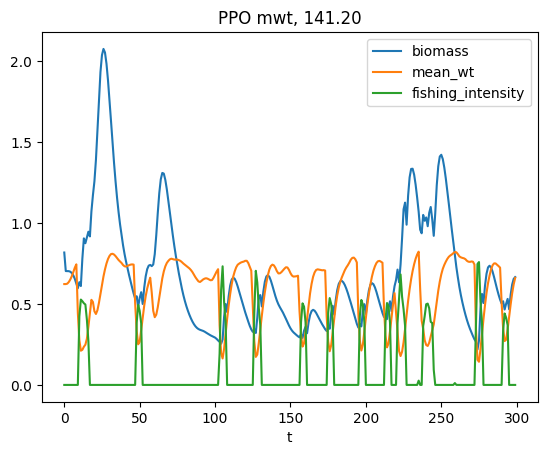

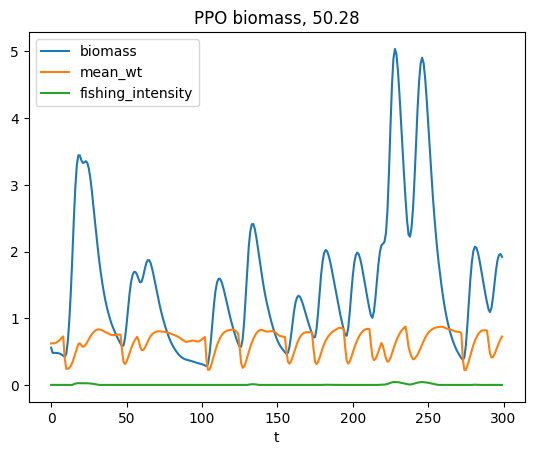

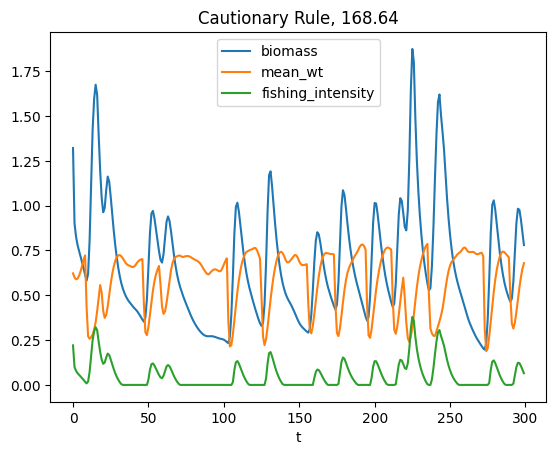

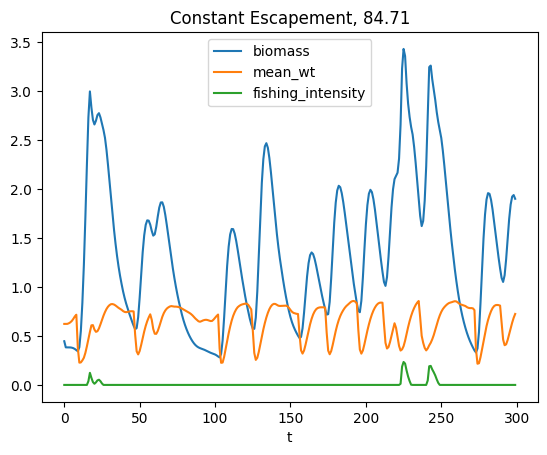

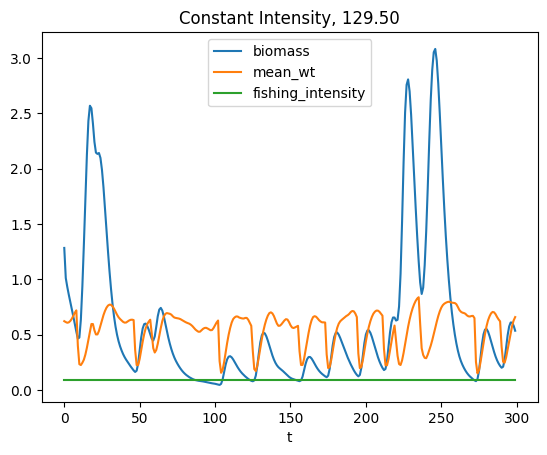

In [60]:
max_t = PLOT_T_MAX

ppo_2o_UM1_ep[ppo_2o_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO 2obs, {sum(ppo_2o_UM1_ep.rew):.2f}',
)
ppo_mw_UM1_ep[ppo_mw_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO mwt, {sum(ppo_mw_UM1_ep.rew):.2f}',
)
ppo_bm_UM1_ep[ppo_bm_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO biomass, {sum(ppo_bm_UM1_ep.rew):.2f}',
)

cr_UM1_ep[cr_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Cautionary Rule, {sum(cr_UM1_ep.rew):.2f}',
)
esc_UM1_ep[esc_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Escapement, {sum(esc_UM1_ep.rew):.2f}',
)
msy_UM1_ep[msy_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Intensity, {sum(msy_UM1_ep.rew):.2f}',
)

<Axes: title={'center': 'Constant Intensity, 129.50'}, xlabel='t'>

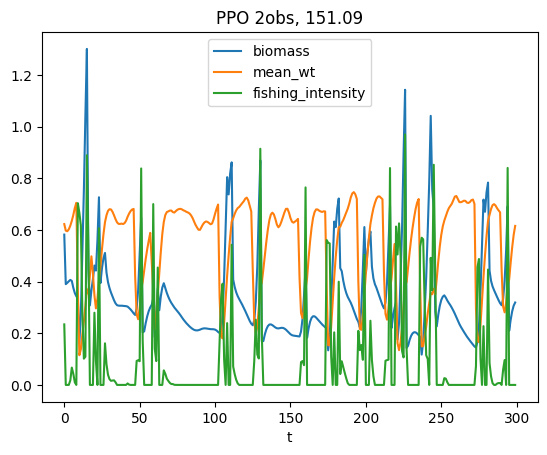

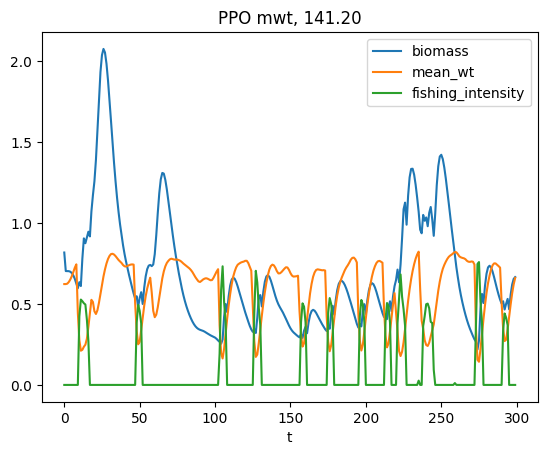

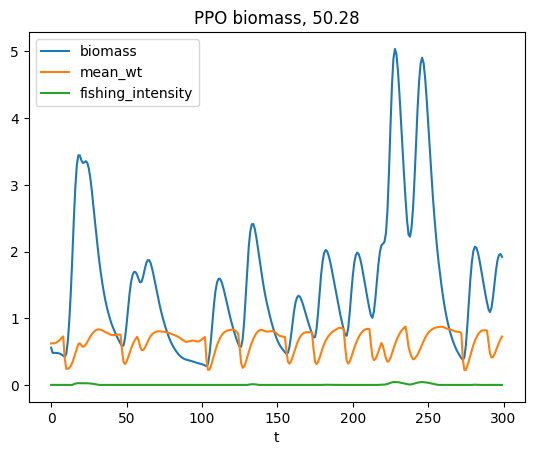

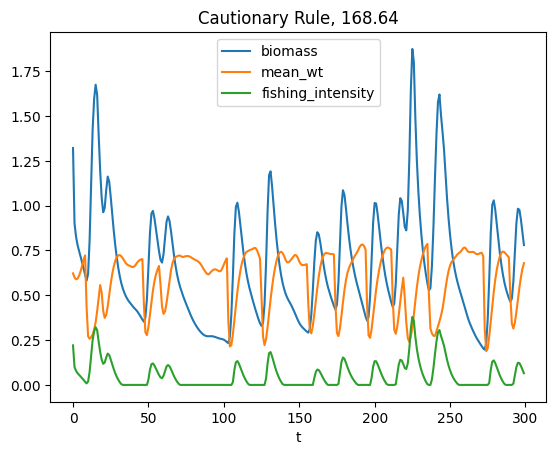

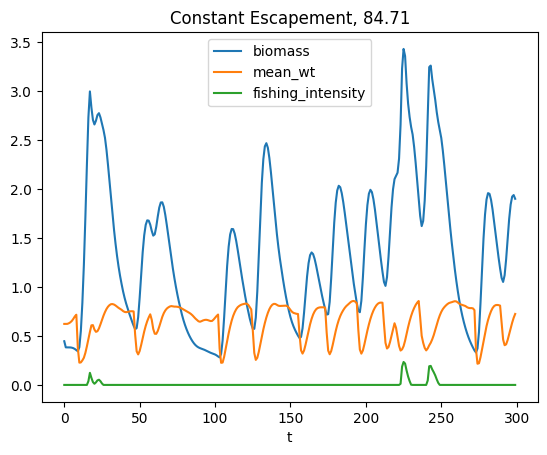

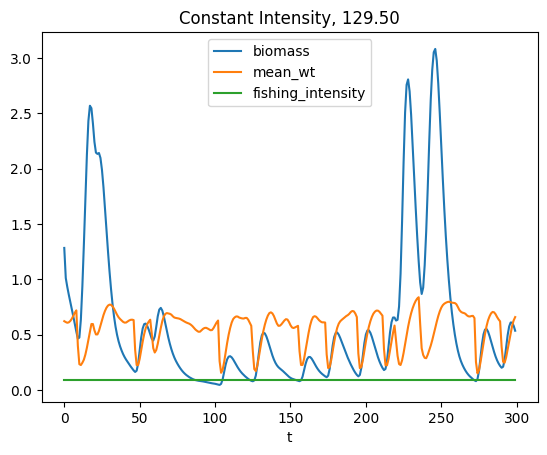

In [61]:
max_t = PLOT_T_MAX

ppo_2o_UM1_ep[ppo_2o_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO 2obs, {sum(ppo_2o_UM1_ep.rew):.2f}',
)
ppo_mw_UM1_ep[ppo_mw_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO mwt, {sum(ppo_mw_UM1_ep.rew):.2f}',
)
ppo_bm_UM1_ep[ppo_bm_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO biomass, {sum(ppo_bm_UM1_ep.rew):.2f}',
)

cr_UM1_ep[cr_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Cautionary Rule, {sum(cr_UM1_ep.rew):.2f}',
)
esc_UM1_ep[esc_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Escapement, {sum(esc_UM1_ep.rew):.2f}',
)
msy_UM1_ep[msy_UM1_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Intensity, {sum(msy_UM1_ep.rew):.2f}',
)

## UM2

In [62]:
ppo_bm_UM2_ep = pd.DataFrame(simulate_episode(env=env_UM2, agent=PPO_bm_UM2, observed_var='bm'))
ppo_2o_UM2_ep = pd.DataFrame(simulate_episode(env=env_UM2, agent=PPO_2o_UM2, observed_var='2o'))
ppo_mw_UM2_ep = pd.DataFrame(simulate_episode(env=env_UM2, agent=PPO_mw_UM2, observed_var='mw'))

cr_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM2, 
    agent = CautionaryRule(
            env = env_UM2,
            **(from_radius_theta(*cr_UM2.x)), 
        ), 
    observed_var='bm',
))

esc_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM2, 
    agent = ConstEsc(
            env = env_UM2,
            escapement=cr_UM2.x[0], 
        ), 
    observed_var='bm',
))

msy_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM2, 
    agent = Msy(
            env = env_UM2,
            mortality=msy_UM2.x[0], 
        ), 
    observed_var='bm',
))

<Axes: title={'center': 'Constant Intensity, 253.39'}, xlabel='t'>

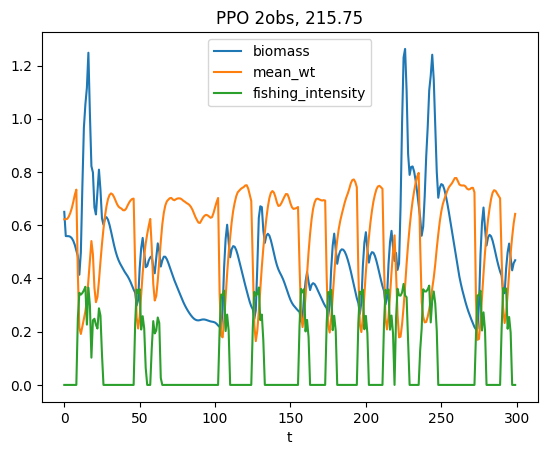

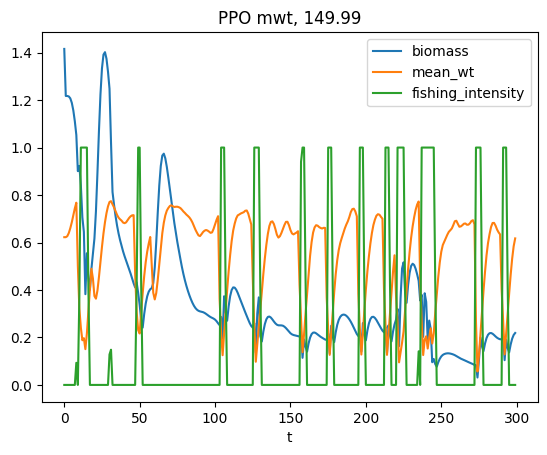

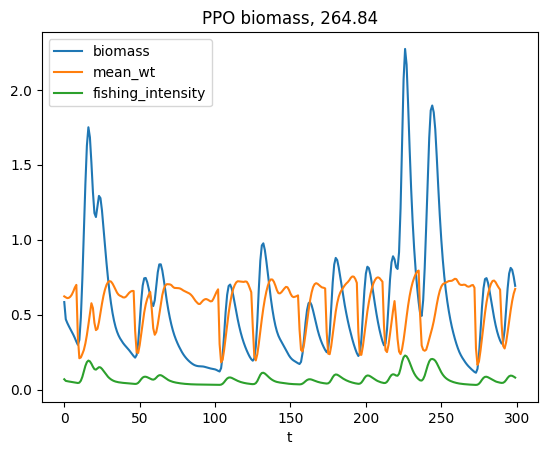

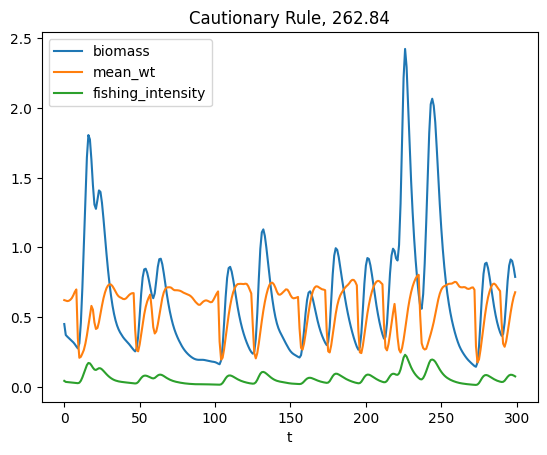

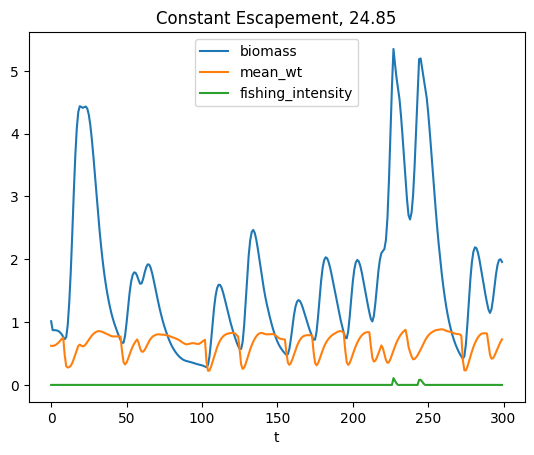

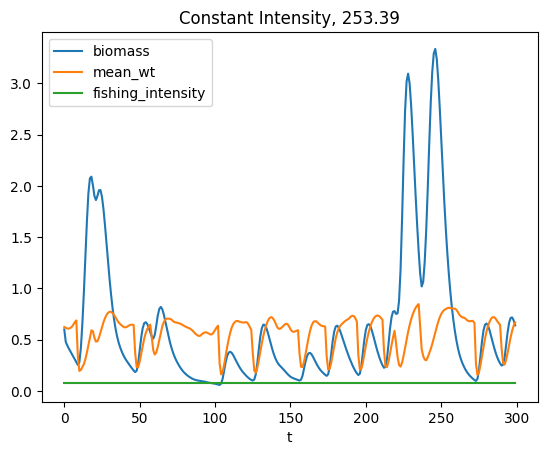

In [63]:
max_t = PLOT_T_MAX

ppo_2o_UM2_ep[ppo_2o_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO 2obs, {sum(ppo_2o_UM2_ep.rew):.2f}',
)
ppo_mw_UM2_ep[ppo_mw_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO mwt, {sum(ppo_mw_UM2_ep.rew):.2f}',
)
ppo_bm_UM2_ep[ppo_bm_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO biomass, {sum(ppo_bm_UM2_ep.rew):.2f}',
)

cr_UM2_ep[cr_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Cautionary Rule, {sum(cr_UM2_ep.rew):.2f}',
)
esc_UM2_ep[esc_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Escapement, {sum(esc_UM2_ep.rew):.2f}',
)
msy_UM2_ep[msy_UM2_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Intensity, {sum(msy_UM2_ep.rew):.2f}',
)

## UM3

In [64]:
ppo_bm_UM3_ep = pd.DataFrame(simulate_episode(env=env_UM3, agent=PPO_bm_UM3, observed_var='bm'))
ppo_2o_UM3_ep = pd.DataFrame(simulate_episode(env=env_UM3, agent=PPO_2o_UM3, observed_var='2o'))
ppo_mw_UM3_ep = pd.DataFrame(simulate_episode(env=env_UM3, agent=PPO_mw_UM3, observed_var='mw'))

cr_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = CautionaryRule(
            env = env_UM3,
            **(from_radius_theta(*cr_UM3.x)), 
        ), 
    observed_var='bm',
))

esc_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = ConstEsc(
            env = env_UM3,
            escapement=cr_UM3.x[0], 
        ), 
    observed_var='bm',
))

msy_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = Msy(
            env = env_UM3,
            mortality=msy_UM3.x[0], 
        ), 
    observed_var='bm',
))

<Axes: title={'center': 'Constant Intensity, 59.22'}, xlabel='t'>

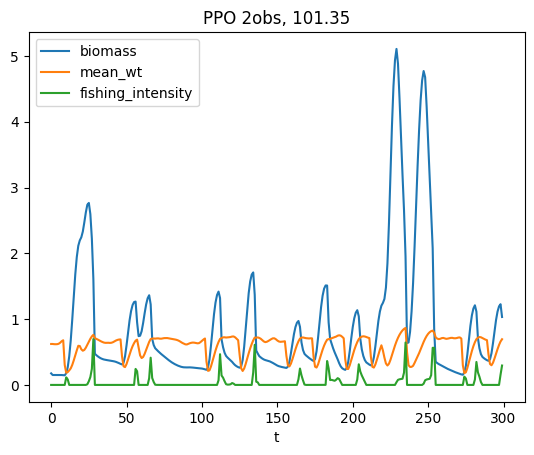

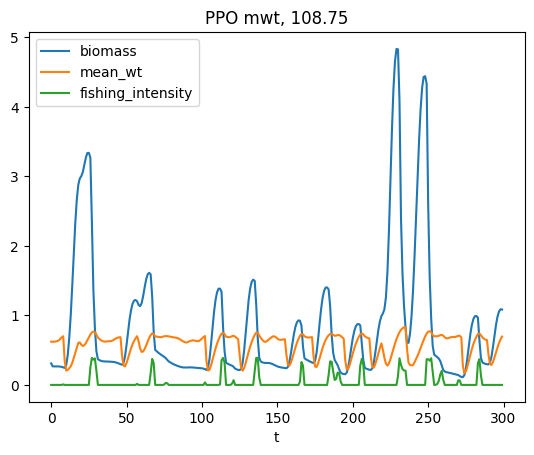

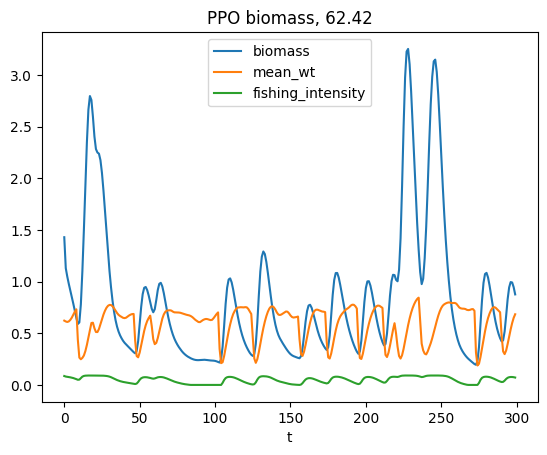

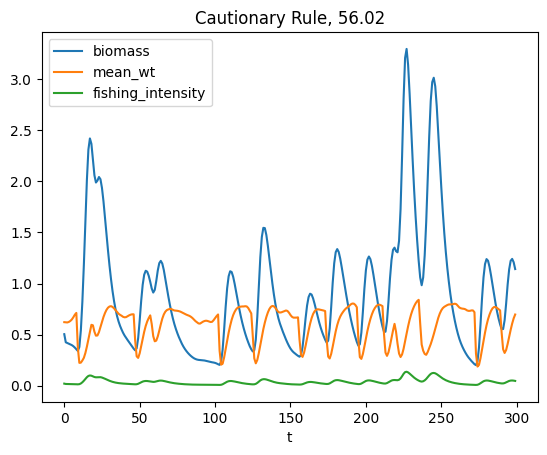

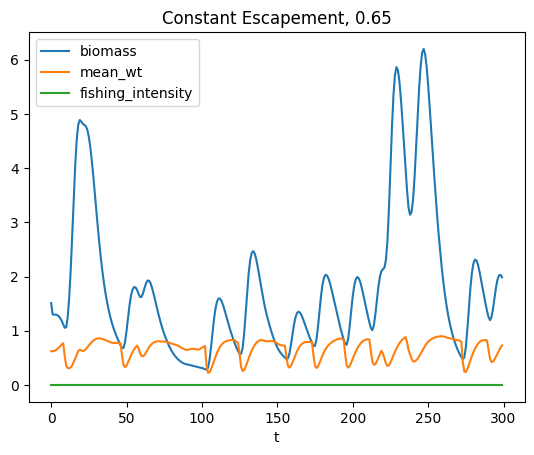

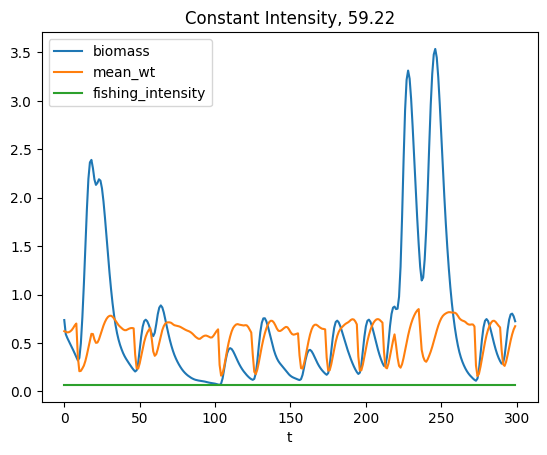

In [65]:
max_t = PLOT_T_MAX

ppo_2o_UM3_ep[ppo_2o_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO 2obs, {sum(ppo_2o_UM3_ep.rew):.2f}',
)
ppo_mw_UM3_ep[ppo_mw_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO mwt, {sum(ppo_mw_UM3_ep.rew):.2f}',
)
ppo_bm_UM3_ep[ppo_bm_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'PPO biomass, {sum(ppo_bm_UM3_ep.rew):.2f}',
)

cr_UM3_ep[cr_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Cautionary Rule, {sum(cr_UM3_ep.rew):.2f}',
)
esc_UM3_ep[esc_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Escapement, {sum(esc_UM3_ep.rew):.2f}',
)
msy_UM3_ep[msy_UM3_ep.t<max_t].plot(
    x='t', 
    y=['biomass', 'mean_wt', 'fishing_intensity'], 
    title= f'Constant Intensity, {sum(msy_UM3_ep.rew):.2f}',
)

## Phase space plot type things

### UM1

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


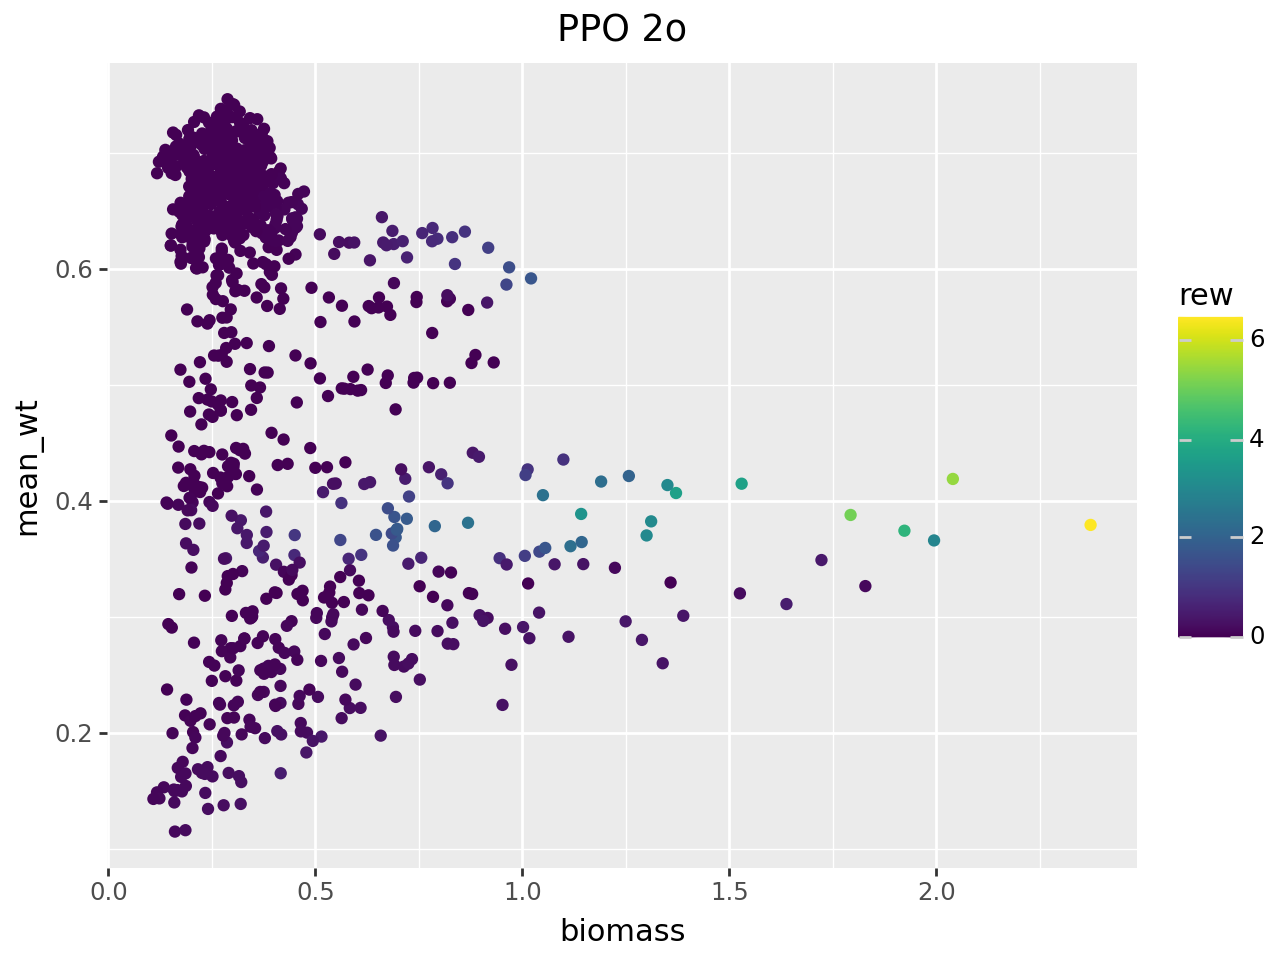

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


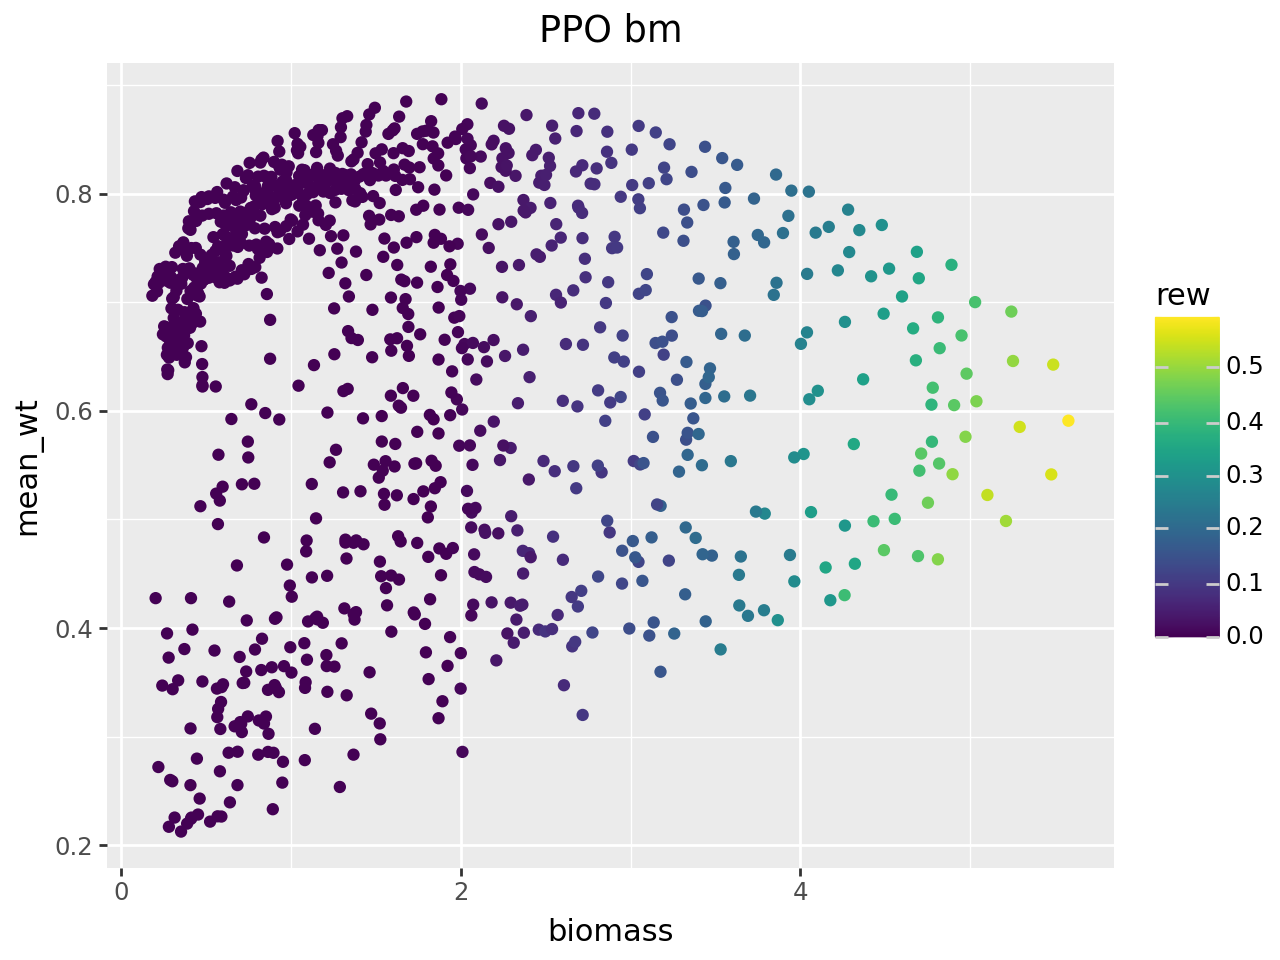

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


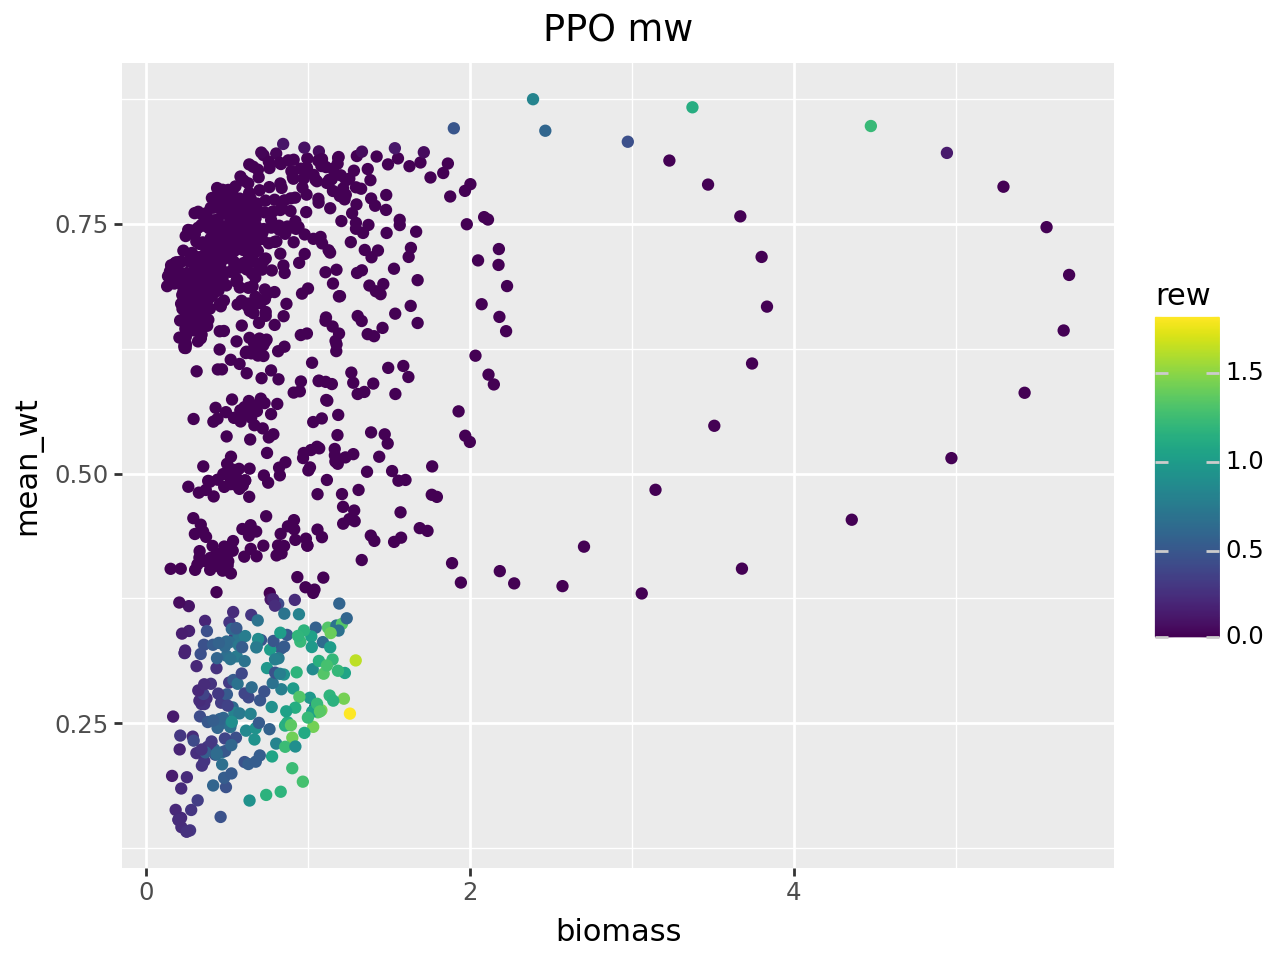

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


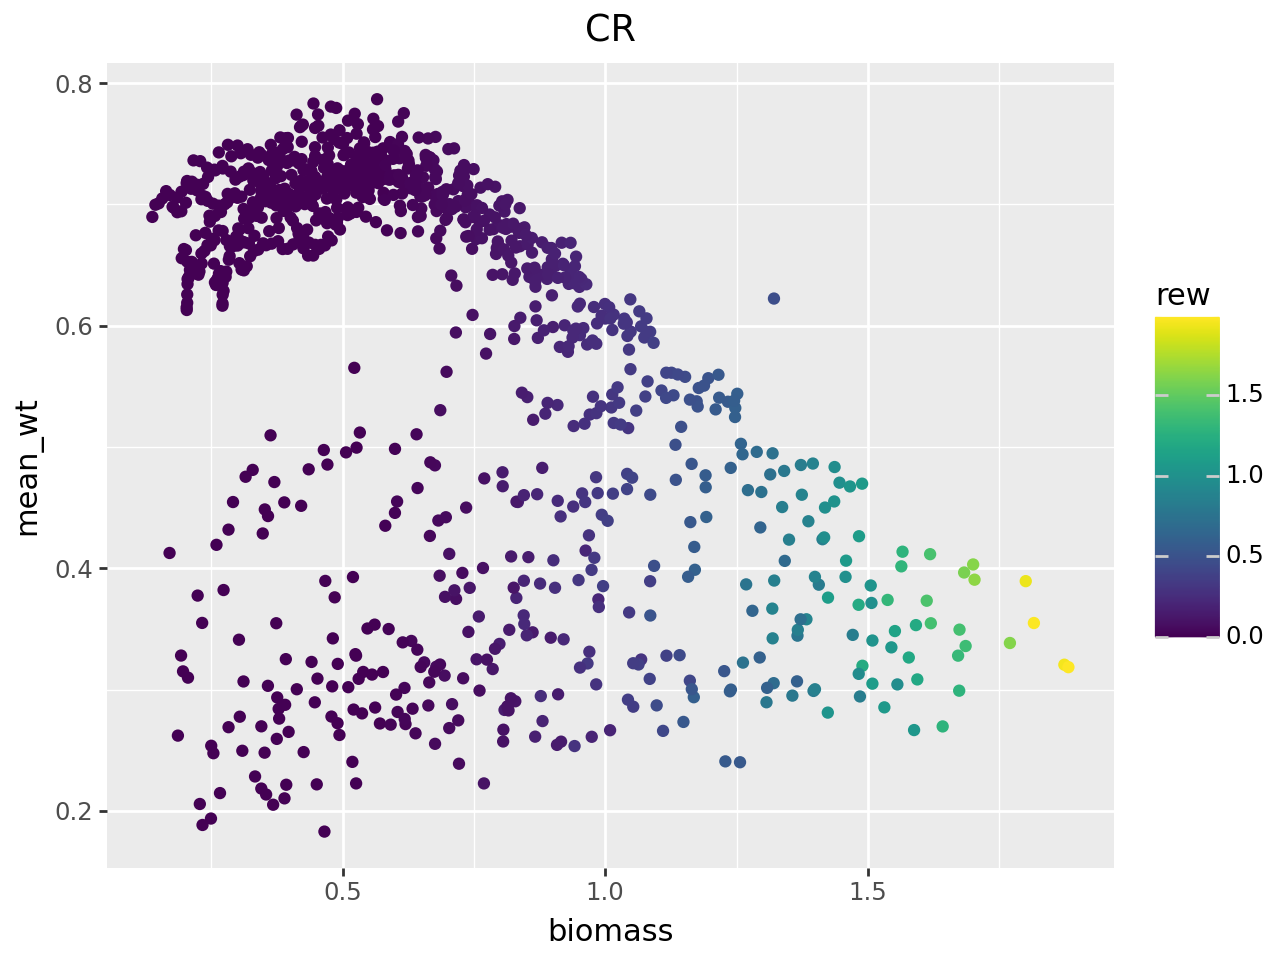

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


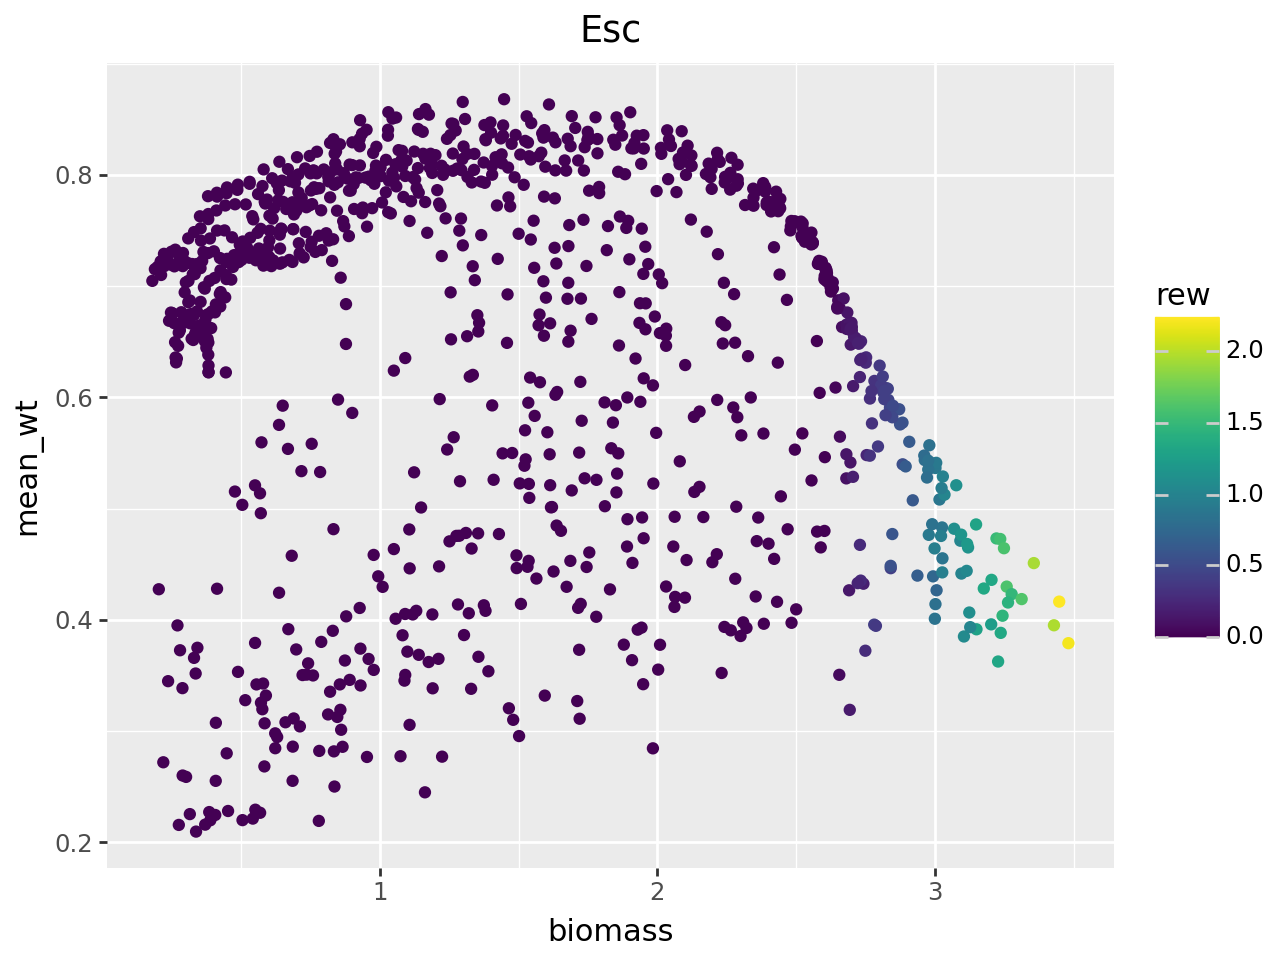

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


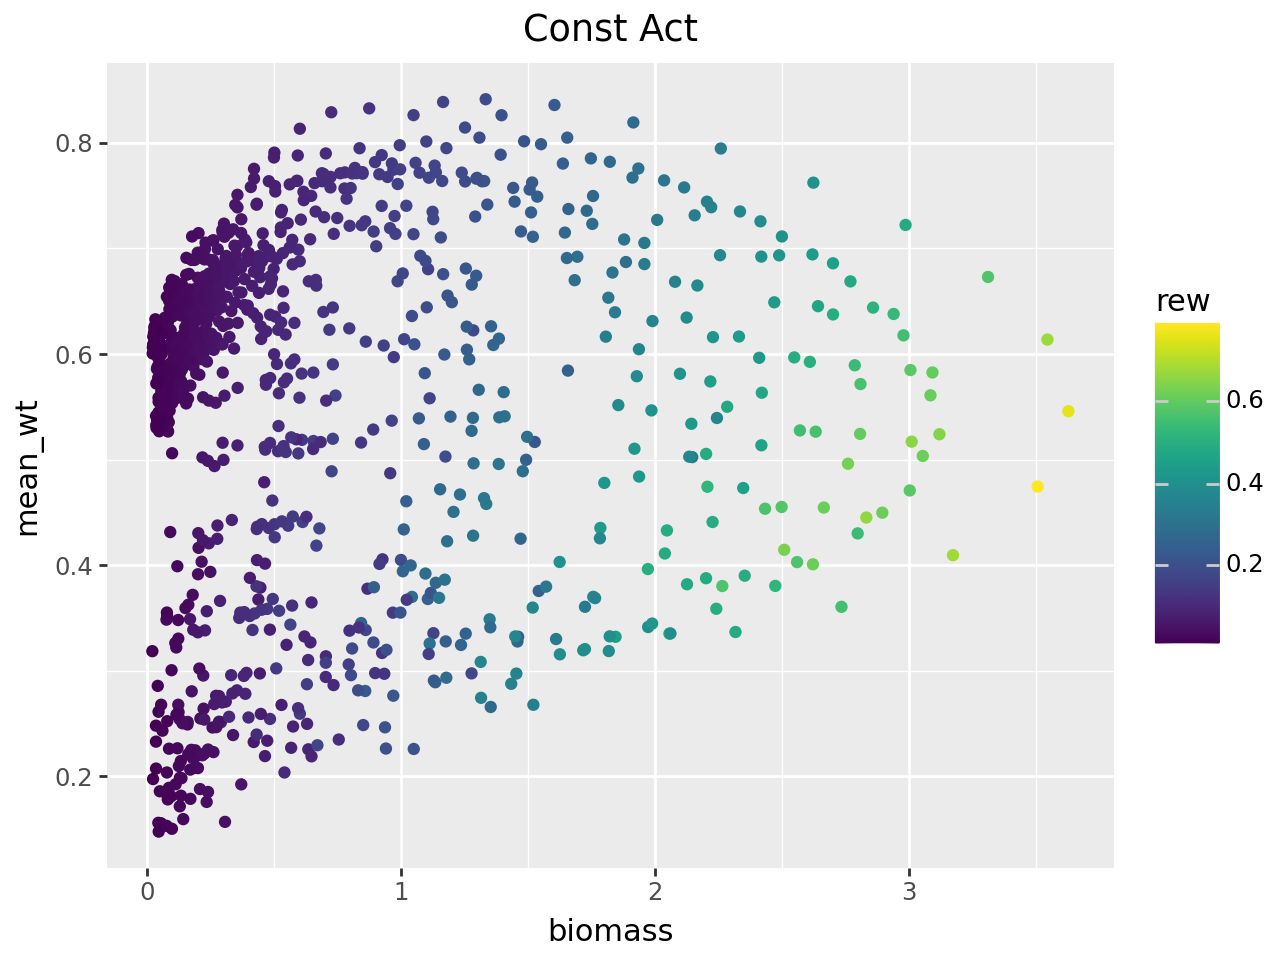

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [66]:
(
    ggplot(ppo_2o_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO 2o'),
    ggplot(ppo_bm_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO bm'),
    ggplot(ppo_mw_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO mw'),
    ggplot(cr_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('CR'),
    ggplot(esc_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Esc'),
    ggplot(msy_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Const Act'),
)

### UM2

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


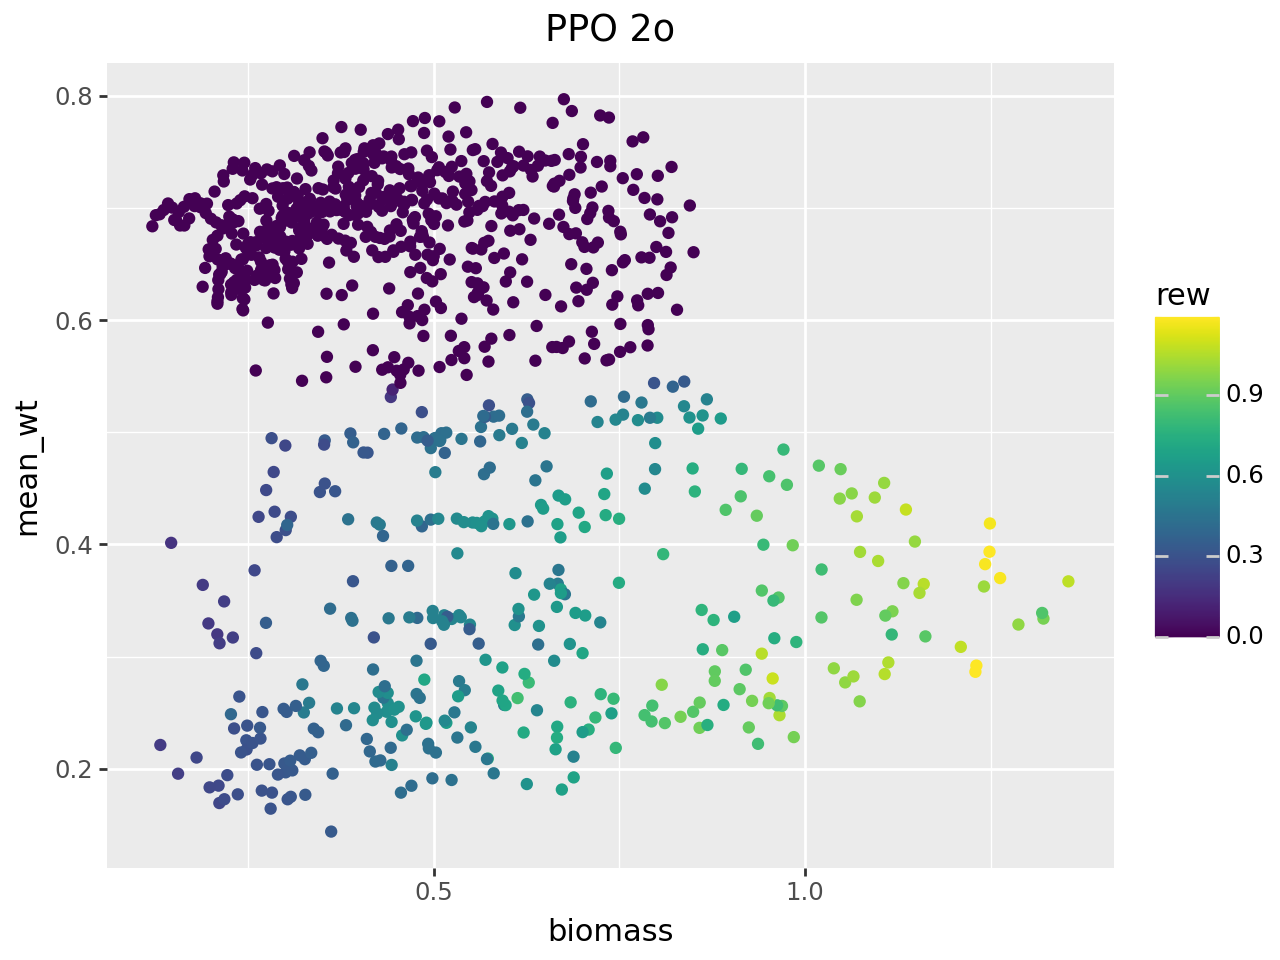

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


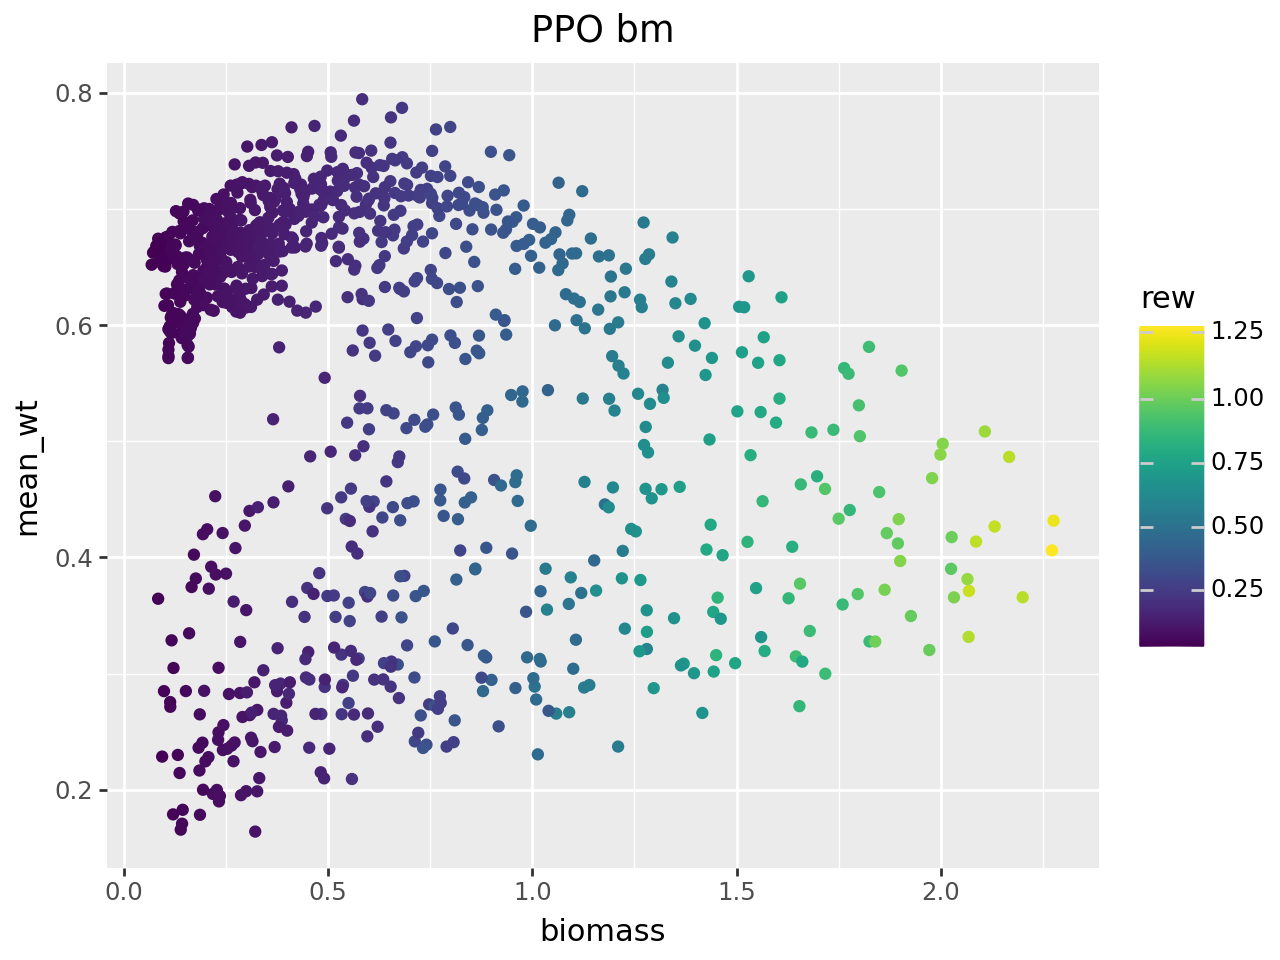

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


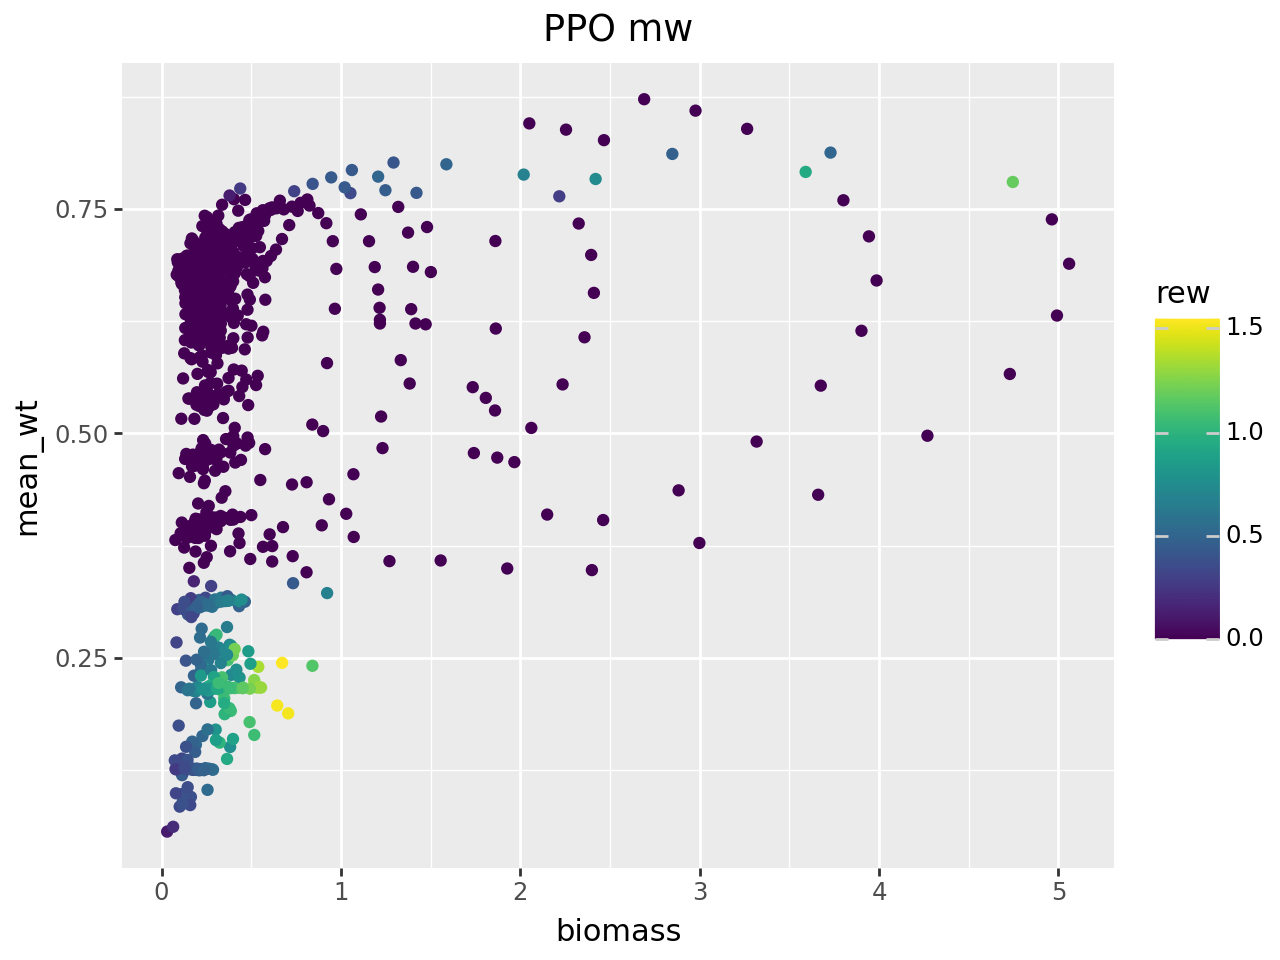

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


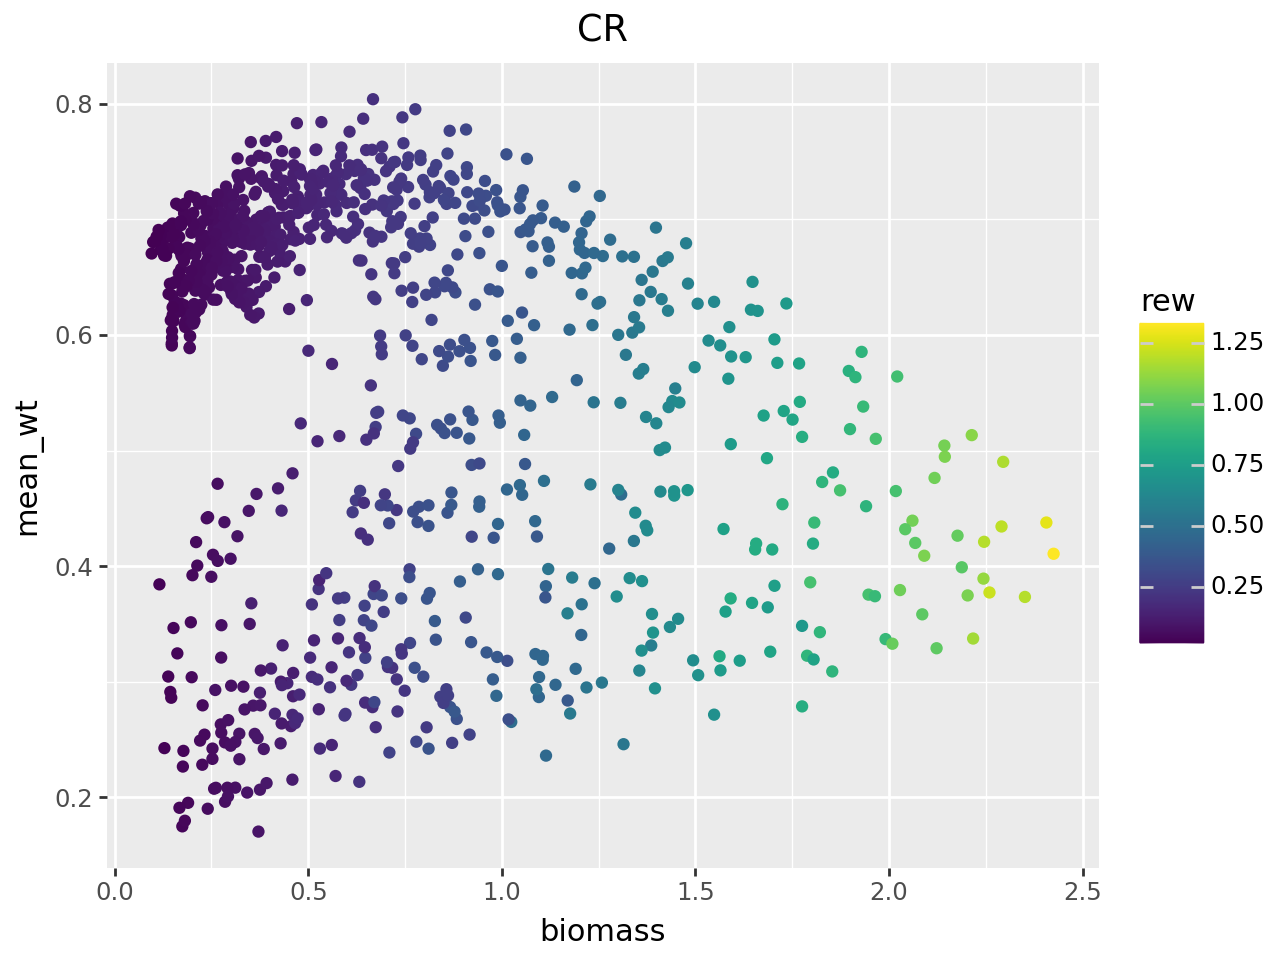

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


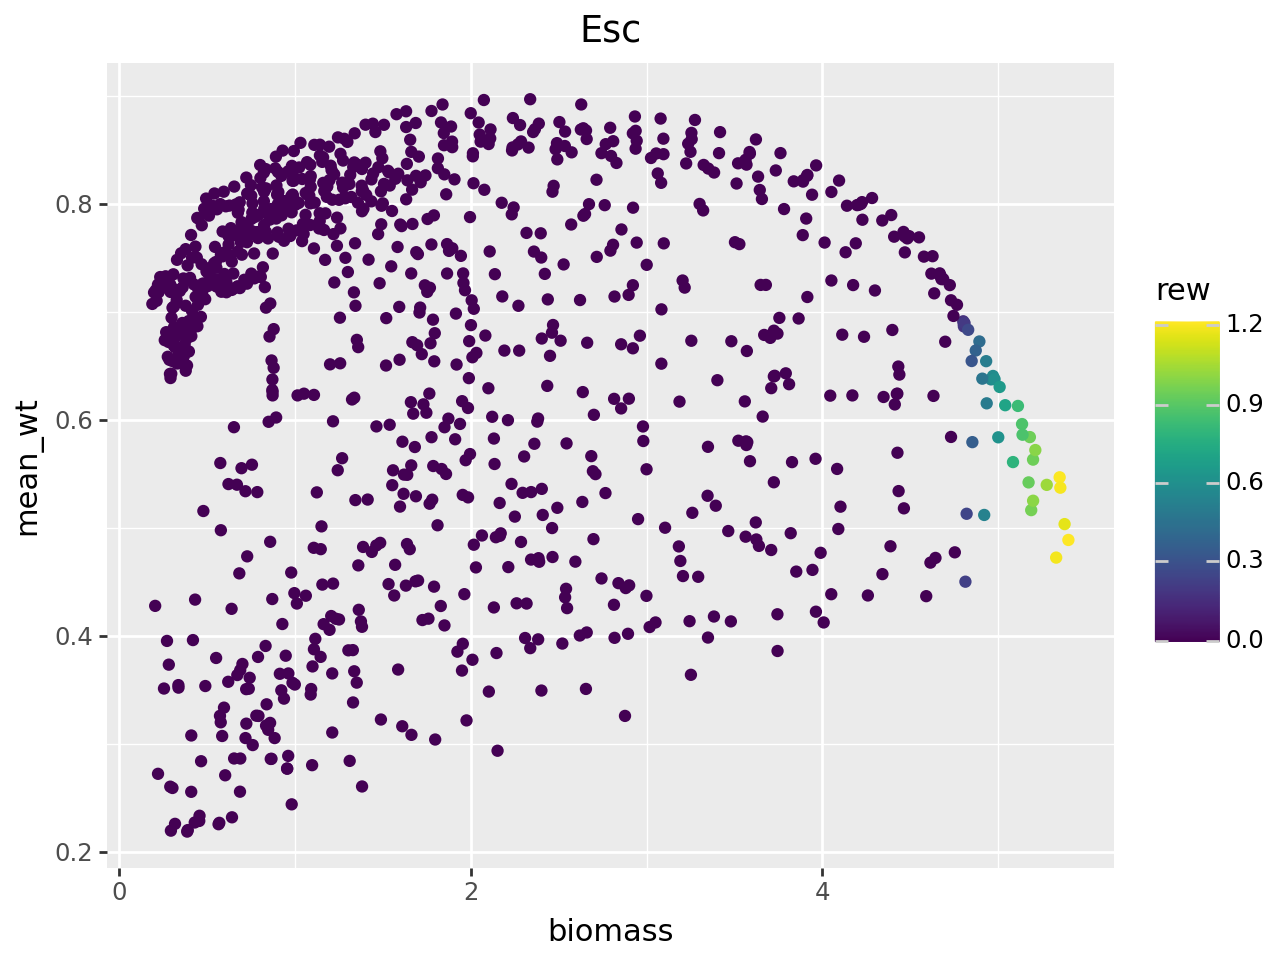

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


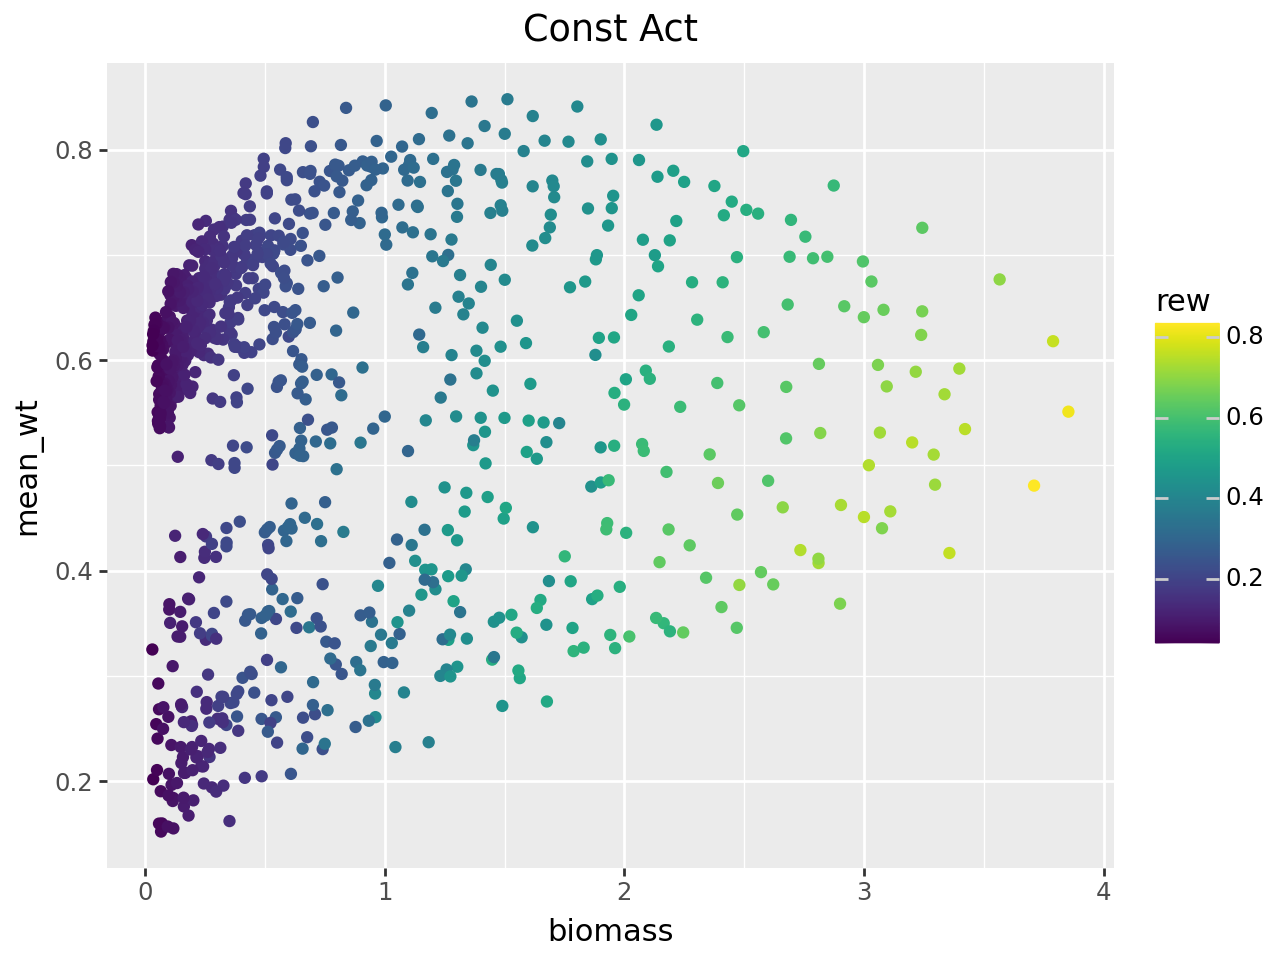

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [67]:
(
    ggplot(ppo_2o_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO 2o'),
    ggplot(ppo_bm_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO bm'),
    ggplot(ppo_mw_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO mw'),
    ggplot(cr_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('CR'),
    ggplot(esc_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Esc'),
    ggplot(msy_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Const Act'),
)

### UM3

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


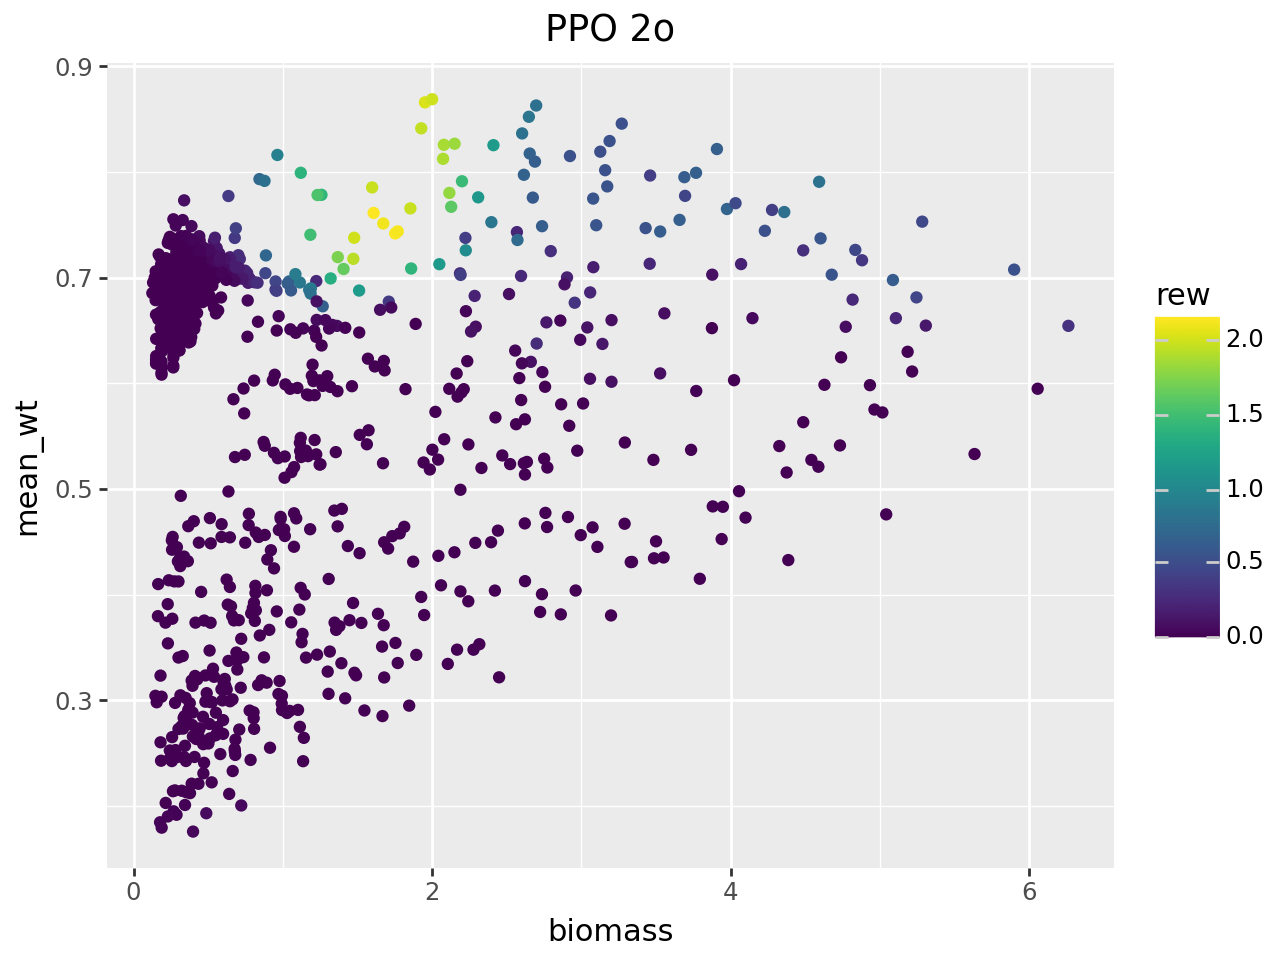

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


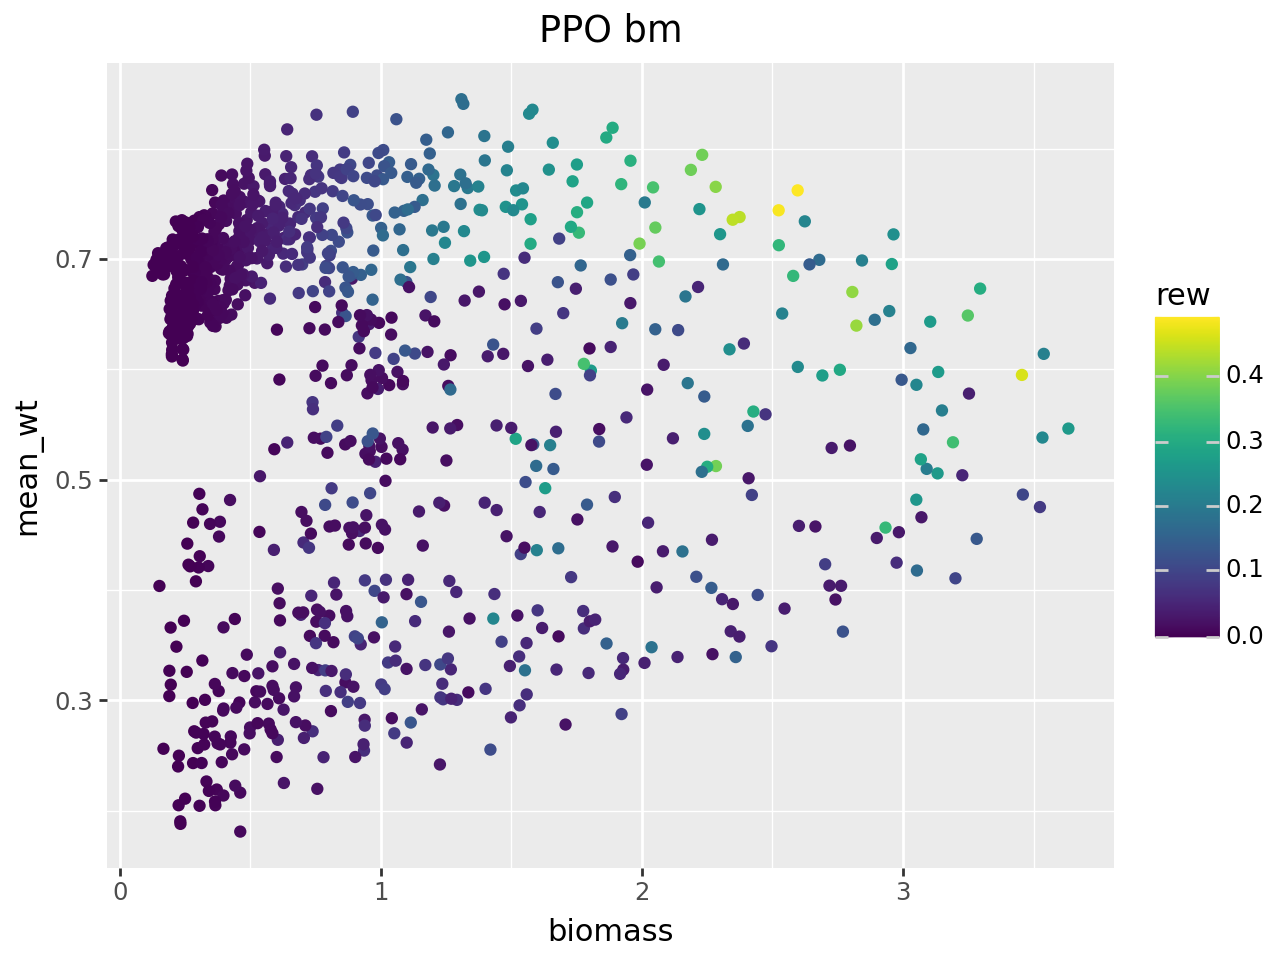

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


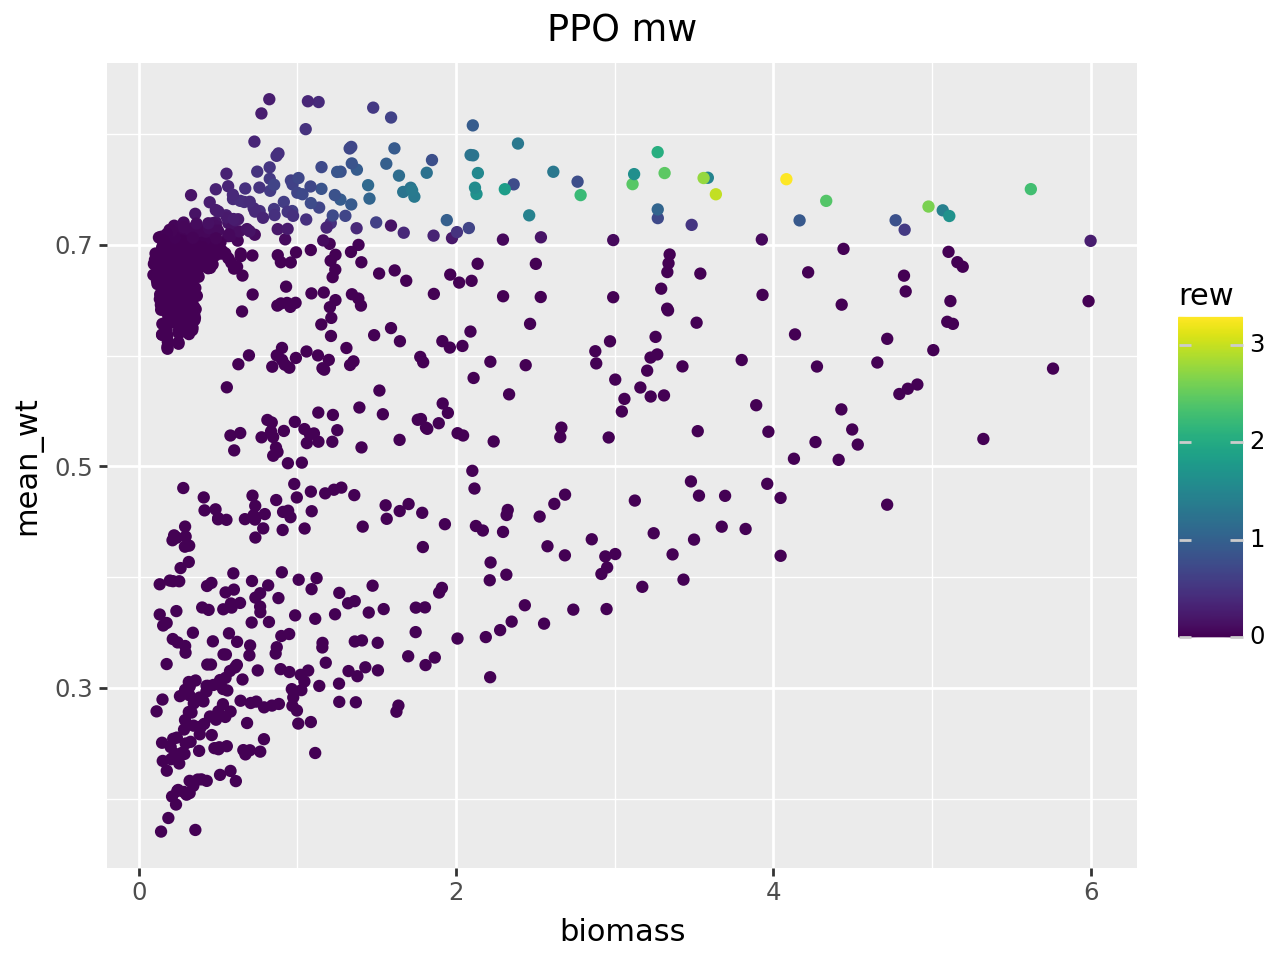

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


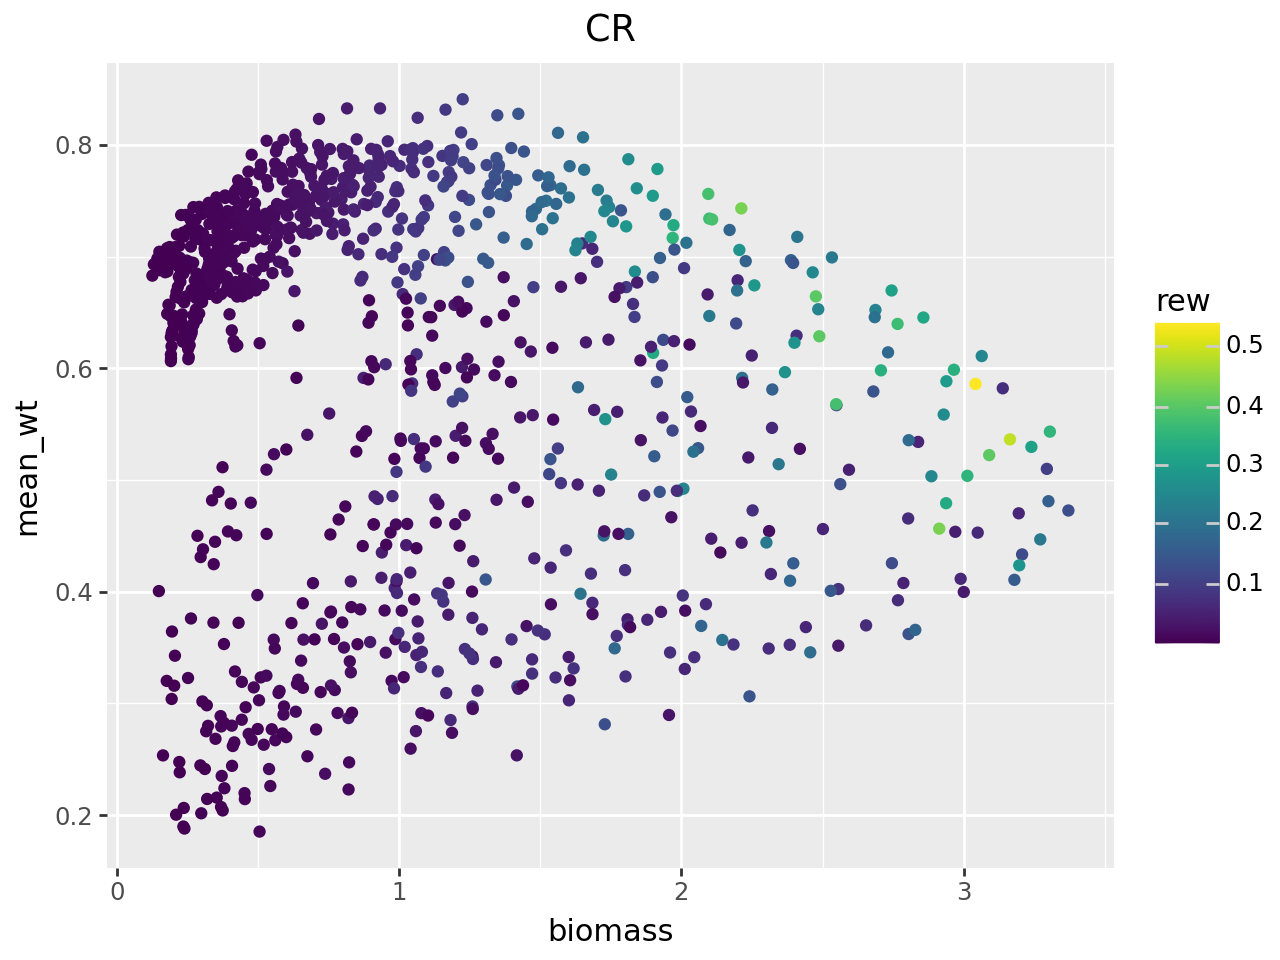

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


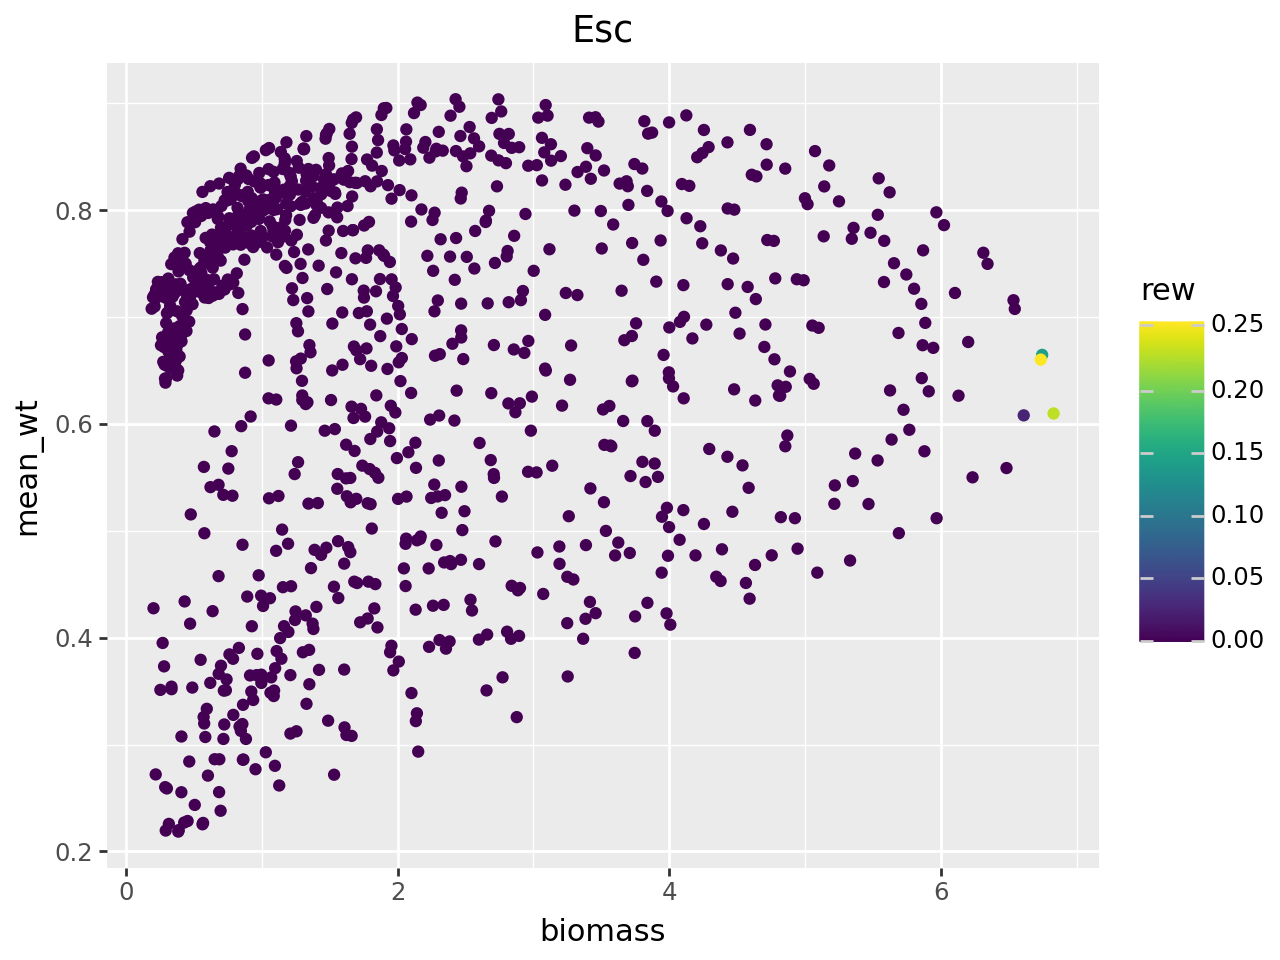

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


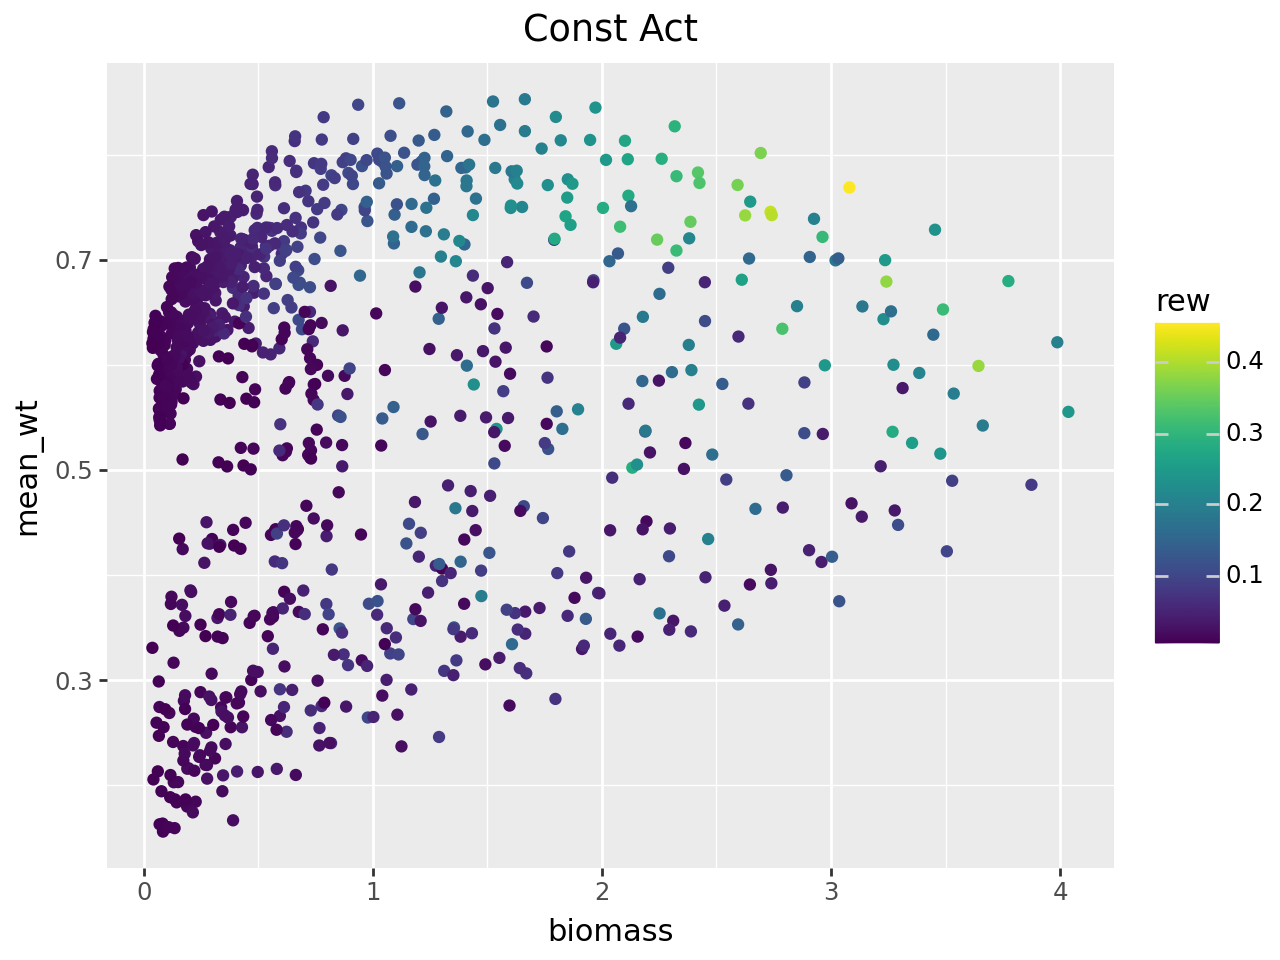

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [68]:
(
    ggplot(ppo_2o_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO 2o'),
    ggplot(ppo_bm_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO bm'),
    ggplot(ppo_mw_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO mw'),
    ggplot(cr_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('CR'),
    ggplot(esc_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Esc'),
    ggplot(msy_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Const Act'),
)